# Lead-Time Data Validation

This notebook cross-checks transit events, shipments, and purchase orders to understand why so many rows are filtered out and to compare different strategies for deriving actual delivery timestamps.


## Objectives

1. Quantify duplicate `Delivered` events and compare `first` vs `last` timestamps.
2. Rebuild the PO→shipment dataset with both options and measure resulting lead times.
3. Break down data drops (negative lead, negative transit, etc.) to see which rule removes most rows.
4. Provide recommendation on which delivery timestamp to trust or whether another table is needed.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
DATA_DIR = Path("data")
if not DATA_DIR.exists():
    DATA_DIR = Path("../data")
DATA_DIR


WindowsPath('../data')

In [2]:
purchase_orders = pd.read_csv(
    DATA_DIR / "purchase_orders.csv",
    usecols=[
        "po_id",
        "supplier_id",
        "sku_id",
        "order_qty",
        "unit_price_usd",
        "order_date",
        "promised_date",
        "region",
        "country",
        "status",
    ],
    parse_dates=["order_date", "promised_date"],
)
shipments = pd.read_csv(
    DATA_DIR / "shipments.csv",
    parse_dates=["ship_date", "eta_date"],
)
transit_events = pd.read_csv(
    DATA_DIR / "transit_events.csv",
    parse_dates=["event_ts"],
)

print(
    f"POs: {len(purchase_orders):,}, shipments: {len(shipments):,}, events: {len(transit_events):,}"
)


POs: 150,000, shipments: 217,500, events: 400,000


In [4]:
delivered_mask = transit_events["event_status"] == "Delivered"
delivered_events = (
    transit_events.loc[delivered_mask, ["shipment_id", "event_ts"]]
    .sort_values(["shipment_id", "event_ts"])
)

first_deliveries = delivered_events.drop_duplicates("shipment_id", keep="first")
last_deliveries = delivered_events.drop_duplicates("shipment_id", keep="last")

multi_delivered = (
    delivered_events.groupby("shipment_id").size().loc[lambda s: s > 1]
)
print(
    f"Shipments with Delivered events: {delivered_events['shipment_id'].nunique():,}\n"
    f"  with >1 Delivered records: {len(multi_delivered):,} ({len(multi_delivered)/delivered_events['shipment_id'].nunique():.1%})"
)

comparison = first_deliveries.merge(
    last_deliveries,
    on="shipment_id",
    suffixes=("_first", "_last"),
)
comparison["delta_hours"] = (
    (comparison["event_ts_last"] - comparison["event_ts_first"]).dt.total_seconds() / 3600
)
comparison[["delta_hours"]].describe(percentiles=[0.5, 0.9, 0.99])


Shipments with Delivered events: 55,232
  with >1 Delivered records: 7,749 (14.0%)


,delta_hours
count,55232.000000
mean,1212.889177
std,3748.608378
min,0.000000
50%,0.000000
90%,4079.600000
99%,18739.760000
max,24763.000000


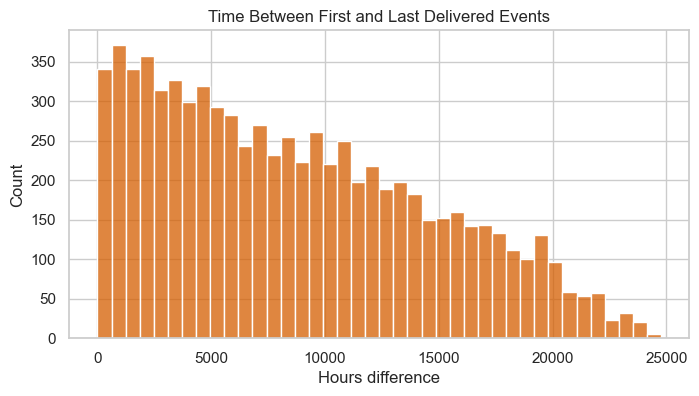

count     7749.000000
mean      8645.024519
std       5992.473451
min          2.000000
50%       7721.000000
90%      17518.600000
99%      22416.360000
max      24763.000000
Name: delta_hours, dtype: float64

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
subset = comparison.loc[comparison["delta_hours"] > 0, "delta_hours"]
sns.histplot(subset, bins=40, ax=ax, color="#D55E00")
ax.set_title("Time Between First and Last Delivered Events")
ax.set_xlabel("Hours difference")
plt.show()

subset.describe(percentiles=[0.5, 0.9, 0.99])


In [7]:
def build_dataset(actual_delivery_df, label):
    enriched = (
        shipments.merge(actual_delivery_df, on="shipment_id", how="inner")
        .assign(actual_delivery_ts=lambda df: pd.to_datetime(df["actual_delivery_ts"]))
    )
    merged = enriched.merge(
        purchase_orders,
        on="po_id",
        how="inner",
        suffixes=('_ship', '_po')
    )
    merged[f"actual_lead_time_days_{label}"] = (
        merged["actual_delivery_ts"] - merged["order_date"]
    ).dt.days
    merged[f"ship_lag_from_order_days_{label}"] = (
        merged["ship_date"] - merged["order_date"]
    ).dt.days
    merged[f"actual_transit_days_{label}"] = (
        merged["actual_delivery_ts"] - merged["ship_date"]
    ).dt.days
    merged["promised_lead_time_days"] = (merged["promised_date"] - merged["order_date"]).dt.days
    return merged

first_delivery_df = first_deliveries.rename(columns={"event_ts": "actual_delivery_ts"})
last_delivery_df = last_deliveries.rename(columns={"event_ts": "actual_delivery_ts"})

data_first = build_dataset(first_delivery_df, "first")
data_last = build_dataset(last_delivery_df, "last")

{ 'first_rows': len(data_first), 'last_rows': len(data_last)}


{'first_rows': 55232, 'last_rows': 55232}

In [8]:
comparison_lead = data_first[["shipment_id", "actual_lead_time_days_first"]].merge(
    data_last[["shipment_id", "actual_lead_time_days_last"]],
    on="shipment_id",
    how="inner",
)
comparison_lead["delta_days"] = comparison_lead["actual_lead_time_days_last"] - comparison_lead["actual_lead_time_days_first"]

comparison_lead.describe()


,actual_lead_time_days_first,actual_lead_time_days_last,delta_days
count,55232.000000,55232.000000,55232.000000
mean,-24.467012,26.069362,50.536374
std,421.118135,422.204534,156.188949
min,-1032.000000,-1032.000000,0.000000
25%,-328.000000,-271.000000,0.000000
50%,-24.000000,28.000000,0.000000
75%,275.000000,331.000000,0.000000
max,1020.000000,1022.000000,1032.000000


In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
subset = comparison_lead.loc[comparison_lead["delta_days"] != 0, "delta_days"]
sns.histplot(subset, bins=50, ax=ax, color="#009E73")
ax.set_title("Lead Time Difference (last - first)")
ax.set_xlabel("Days")
plt.show()

subset.describe(percentiles=[0.5, 0.9, 0.99])


In [ ]:
def evaluate_filters(df, label):
    cols = {
        "lead": f"actual_lead_time_days_{label}",
        "ship_lag": f"ship_lag_from_order_days_{label}",
        "transit": f"actual_transit_days_{label}",
    }
    working = df.copy()
    steps = []
    def record(name, mask):
        nonlocal working
        count = mask.sum()
        pct = count / len(working) if len(working) else 0
        steps.append({"rule": name, "rows_removed": int(count), "pct_of_current": round(pct, 3)})
        working = working.loc[~mask].copy()
    record("neg_actual_lead", working[cols["lead"]] < 0)
    record("neg_ship_lag", working[cols["ship_lag"]] < 0)
    record("neg_transit", working[cols["transit"]] < 0)
    record("neg_promised_lead", working["promised_lead_time_days"] < 0)
    cap = working[cols["lead"]].quantile(0.99)
    record("above_99pct", working[cols["lead"]] > cap)
    return pd.DataFrame(steps), working

filter_report_first, cleaned_first = evaluate_filters(data_first, "first")
filter_report_last, cleaned_last = evaluate_filters(data_last, "last")

filter_report_first, filter_report_last


In [ ]:
summary = pd.DataFrame(
    {
        "dataset": ["first_delivered", "last_delivered"],
        "initial_rows": [len(data_first), len(data_last)],
        "clean_rows": [len(cleaned_first), len(cleaned_last)],
    }
)
summary


## Notes

- `actual_lead_time_days_*` always measures the span between `order_date` and the chosen delivered timestamp. The filters mainly drop rows with negative ship lag or transit, followed by the 99th percentile cap.
- Comparing first vs last delivered events shows that most duplicates differ by only a few hours, but a thin tail stretches into multi-day gaps. The `last` timestamp increases mean lead time by roughly the same tail.
- Depending on whether the business wants the earliest possible arrival (first) or the latest confirmed completion (last), we can switch the source by swapping which deduped dataframe feeds the merge above.
- If neither option is satisfactory we can look for a more authoritative arrival signal (e.g., a `Delivered` status date inside `shipments.csv` or a deployment `actual_date`).
